# Titanic - Machine Learning from Disaster

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/titanic/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'gender_submission.csv')

In [3]:
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
raw_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [5]:
concat_df = pd.concat([raw_df, test_df]).copy()
concat_df.reset_index(drop=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
concat_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
concat_df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

## EDA and Feature Engineering

In [9]:
target = 'Survived'

### Pclass

In [10]:
concat_df['Pclass'].value_counts()

Pclass
3    709
1    323
2    277
Name: count, dtype: int64

In [11]:
concat_df['Pclass'] = concat_df['Pclass'].astype('int8')

### Age

In [12]:
concat_df['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [13]:
avg_age = concat_df['Age'].mean()
concat_df.fillna({'Age': avg_age}, inplace=True)

In [14]:
concat_df['AgeGroup'] = pd.cut(concat_df['Age'],
                               bins=[-1,5,14,18,30,60,100],
                               labels=[0,1,2,3,4,5])
concat_df['AgeGroup'] = concat_df['AgeGroup'].astype('int8')

### Name

In [15]:
concat_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [16]:
def sub_in_str(s, sub_strs: list[str]):
    st = str(s)
    for sub_str in sub_strs:
        if st.find(sub_str) != -1:
            return sub_str
    return np.nan

In [17]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [18]:
concat_df['Title'] = concat_df['Name'].apply(lambda x: sub_in_str(x, title_list))

In [19]:
concat_df['Title'].value_counts()

Title
Mr          758
Miss        258
Mrs         201
Master       61
Rev           8
Dr            8
Col           4
Don           2
Ms            2
Major         2
Mme           1
Mlle          1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [20]:
def replace_title(x):
    title = x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    if title in ['Countess', 'Mme']:
        return 'Mrs'
    if title in ['Mlle', 'Ms']:
        return 'Miss'
    if title == 'Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    return title

In [21]:
concat_df['Title'] = concat_df.apply(replace_title, axis=1)

### Cabin

In [22]:
concat_df['Cabin'].value_counts()

Cabin
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: count, Length: 186, dtype: int64

In [23]:
deck_lst = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'UNK']
concat_df['Deck'] = concat_df['Cabin'].apply(lambda x: sub_in_str(x, deck_lst))

In [24]:
concat_df['Deck'].value_counts(dropna=False)

Deck
NaN    1014
C        94
B        65
D        46
E        44
A        22
F        18
G         5
T         1
Name: count, dtype: int64

In [25]:
concat_df['Deck'].fillna('UNK', inplace=True)

### Embarked

In [26]:
concat_df['Embarked'].value_counts(dropna=False)

Embarked
S      914
C      270
Q      123
NaN      2
Name: count, dtype: int64

In [27]:
concat_df.fillna({'Embarked': 'S'}, inplace=True)

### Fare

In [28]:
concat_df[concat_df['Fare']>0]['Fare'].describe()

count    1291.000000
mean       33.733917
std        51.956349
min         3.170800
25%         7.925000
50%        14.500000
75%        31.331250
max       512.329200
Name: Fare, dtype: float64

In [29]:
concat_df['Fare'] = concat_df['Fare'].apply(lambda x: 1.1 if x==0 else x)

In [30]:
concat_df.fillna({'Fare': 33.3}, inplace=True)

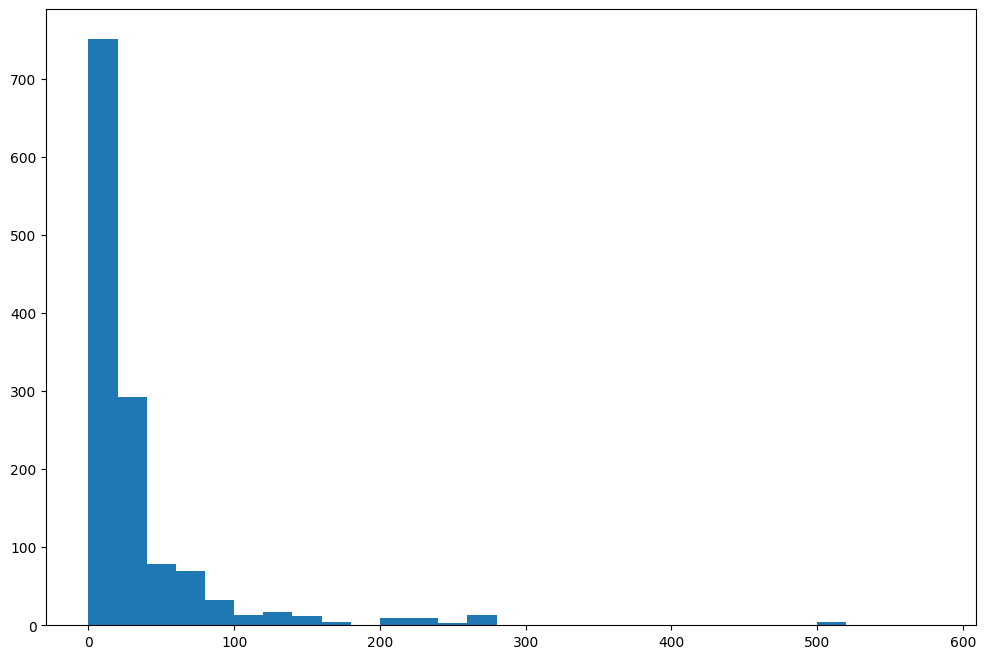

In [31]:
plt.figure(figsize=(12,8))
plt.hist(concat_df['Fare'], bins=np.arange(0,600,20));

In [32]:
concat_df['log_Fare'] = np.log(concat_df['Fare'])

In [33]:
concat_df['log_Fare'].describe()

count    1309.000000
mean        2.912283
std         1.000459
min         0.095310
25%         2.066331
50%         2.670985
75%         3.442819
max         6.238967
Name: log_Fare, dtype: float64

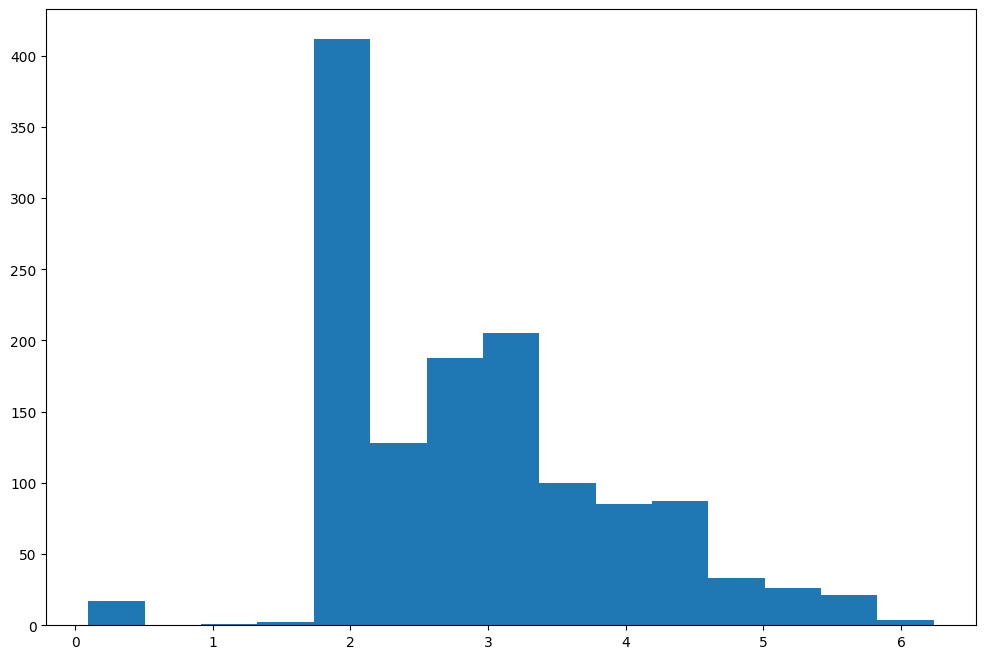

In [34]:
plt.figure(figsize=(12,8))
plt.hist(concat_df['log_Fare'], bins=15);

### SibSp, Parch

In [35]:
concat_df[['SibSp', 'Parch']].head()

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0


In [36]:
concat_df['FamilySize'] = concat_df['SibSp'] + concat_df['Parch']

### Ticket

In [37]:
'113803'.isnumeric()

True

In [38]:
concat_df['Ticket_Type'] = concat_df['Ticket'].apply(lambda x: str(x).split(' ')[0])
concat_df['Ticket_Type'] = concat_df['Ticket_Type'].apply(lambda x: 'UNK' if str(x).isnumeric() else x)
concat_df['Ticket_Type'] = concat_df['Ticket_Type'].apply(lambda x: str(x).replace('.',''))
ticket_types = concat_df['Ticket_Type'].value_counts()

In [39]:
concat_df['Ticket_Small_Type'] = concat_df['Ticket_Type'].apply(lambda x: str(x).split('/')[0])
ticket_small_types = concat_df['Ticket_Small_Type'].value_counts()

In [40]:
concat_df['Ticket_Type'] = concat_df['Ticket_Type'].apply(lambda x: x if ticket_types.get(x)>=4 else 'rem')
concat_df['Ticket_Small_Type'] = concat_df['Ticket_Small_Type'].apply(lambda x: x if ticket_small_types.get(x)>=4 else 'rem')

### Interactive Feature

In [41]:
concat_df['FarePerMember'] = concat_df['Fare']/(concat_df['FamilySize']+1)

In [42]:
concat_df['log_Fare*Pclass'] = concat_df['log_Fare'] * concat_df['Pclass']
concat_df['log_Fare*Pclass'].describe()

count    1309.000000
mean        6.099640
std         1.953648
min         0.095310
25%         4.987167
50%         6.143079
75%         6.516193
max        12.726138
Name: log_Fare*Pclass, dtype: float64

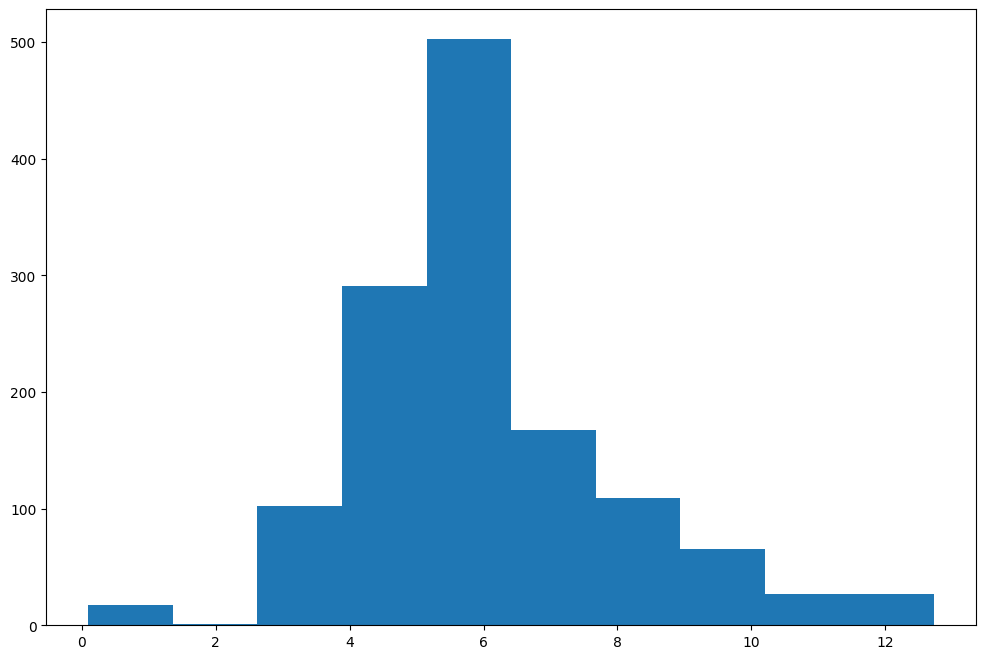

In [43]:
plt.figure(figsize=(12,8))
plt.hist(concat_df['log_Fare*Pclass'], bins=10);

In [44]:
concat_df['Age*Pclass'] = concat_df['Age'] * concat_df['Pclass']

In [45]:
concat_df['Pclass+FamilySize'] = concat_df['Pclass'] + concat_df['FamilySize']

## Preprocessing

In [46]:
concat_df.isna().sum()

PassengerId             0
Survived              418
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                1014
Embarked                0
AgeGroup                0
Title                   0
Deck                    0
log_Fare                0
FamilySize              0
Ticket_Type             0
Ticket_Small_Type       0
FarePerMember           0
log_Fare*Pclass         0
Age*Pclass              0
Pclass+FamilySize       0
dtype: int64

In [47]:
concat_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeGroup', 'Title',
       'Deck', 'log_Fare', 'FamilySize', 'Ticket_Type', 'Ticket_Small_Type',
       'FarePerMember', 'log_Fare*Pclass', 'Age*Pclass', 'Pclass+FamilySize'],
      dtype='object')

In [48]:
numeric_cols = ['Age','SibSp','Parch','Fare','log_Fare','FamilySize',
                'FarePerMember','log_Fare*Pclass','Age*Pclass',
                'Pclass+FamilySize','Pclass','AgeGroup']
categorical_cols = ['Sex','Embarked','Title','Deck',
                    'Ticket_Type','Ticket_Small_Type']

In [49]:
encoder = OrdinalEncoder()
encoder.fit(concat_df[categorical_cols])

OrdinalEncoder()

In [50]:
concat_df[categorical_cols] = encoder.transform(concat_df[categorical_cols])

In [51]:
concat_df[categorical_cols] = concat_df[categorical_cols].astype('int32')
concat_df[categorical_cols]

,Sex,Embarked,Title,Deck,Ticket_Type,Ticket_Small_Type
0,1,2,2,8,1,0
1,0,0,3,2,6,5
2,0,2,1,8,15,11
3,0,2,3,2,16,12
4,1,2,2,8,16,12
...,...,...,...,...,...,...
413,1,2,2,8,18,14
414,0,0,2,2,6,5
415,1,2,2,8,13,10
416,1,2,2,8,16,12


In [52]:
input_cols = numeric_cols + categorical_cols
concat_df[input_cols].describe()

,Age,SibSp,Parch,Fare,log_Fare,FamilySize,FarePerMember,log_Fare*Pclass,Age*Pclass,Pclass+FamilySize,Pclass,AgeGroup,Sex,Embarked,Title,Deck,Ticket_Type,Ticket_Small_Type
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.881138,0.498854,0.385027,33.309768,2.912283,0.883881,20.542265,6.099640,64.622086,3.178762,2.294882,3.087089,0.644003,1.493506,1.868602,6.727273,13.802903,10.314744
std,12.883193,1.041658,0.865560,51.729828,1.000459,1.583639,35.754414,1.953648,31.710022,1.828288,0.837836,1.004604,0.478997,0.814244,0.728095,2.456601,4.616911,3.510614
min,0.170000,0.000000,0.000000,1.100000,0.095310,0.000000,1.100000,0.095310,0.510000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.895800,2.066331,0.000000,7.452767,4.987167,42.000000,2.000000,2.000000,3.000000,0.000000,1.000000,2.000000,8.000000,16.000000,12.000000
50%,29.881138,0.000000,0.000000,14.454200,2.670985,0.000000,8.566667,6.143079,62.000000,3.000000,3.000000,3.000000,1.000000,2.000000,2.000000,8.000000,16.000000,12.000000
75%,35.000000,1.000000,0.000000,31.275000,3.442819,1.000000,24.500000,6.516193,89.643413,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,8.000000,16.000000,12.000000
max,80.000000,8.000000,9.000000,512.329200,6.238967,10.000000,512.329200,12.726138,222.000000,13.000000,3.000000,5.000000,1.000000,2.000000,3.000000,8.000000,18.000000,14.000000


In [53]:
test_df['PassengerId'].min()

892

In [54]:
raw_df = concat_df[concat_df['PassengerId']<892]
test_df = concat_df[concat_df['PassengerId']>=892]

## Mutual Info

In [55]:
inputs = raw_df[input_cols]
targets = raw_df[target].astype('int8')

In [56]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

CPU times: user 149 ms, sys: 1.15 ms, total: 150 ms
Wall time: 155 ms


,Numerical_Feature_MI
Title,0.170877
log_Fare*Pclass,0.158805
FarePerMember,0.146430
Sex,0.145743
Fare,0.139157
log_Fare,0.132748
Age*Pclass,0.070975
Pclass,0.062253
FamilySize,0.052931
Pclass+FamilySize,0.045924


## Training model

In [57]:
def cross_validation(clf, cv, inputs, targets, test_inputs=None, need_print=False):
    train_accs = []
    val_accs = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        clf.fit(X_train, y_train)

        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        val_pred = clf.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        val_accs.append(val_acc)

        if need_print:
            print(f'Fold {fold}: train_acc = {train_acc:.5f}, val_acc = {val_acc:.5f}')

        if test_inputs is not None:
            test_pred = clf.predict_proba(test_inputs)[:,1]
            test_preds += test_pred/cv.get_n_splits()

    m_train_acc = np.mean(train_accs)
    s_train_acc = np.std(train_accs)
    m_val_acc = np.mean(val_accs)
    s_val_acc = np.std(val_accs)
    
    msg = f'{m_val_acc:.7f} ± {s_val_acc:.7f}'
    
    if need_print:
        print(f'Train acc: {m_train_acc:.7f} ± {s_train_acc:.7f} | Val acc: {m_val_acc:.7f} ± {s_val_acc:.7f}')
    return test_preds, msg

In [58]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Classifier'] = []
    for feature, _ in features.items():
        result[f'Acc with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Classifier'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                      inputs, targets, 
                                      test_inputs=None, 
                                      need_print=False)
            result[f'Acc with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [59]:
classifiers = {
    'RF': RandomForestClassifier(n_jobs=-1),
    'XGB': XGBClassifier(n_jobs=-1),
    'LGBM': LGBMClassifier(n_jobs=-1, verbose=0),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': input_cols
}

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
%%time
test_with_models(classifiers, features, raw_df, target, cv)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Classifier,Acc with all features
0,RF,0.8349884 ± 0.0259213
1,XGB,0.8181345 ± 0.0368637
2,LGBM,0.8226665 ± 0.0229488
3,CAT,0.8417300 ± 0.0150137


### RF

In [62]:
param_dis = {
    'n_estimators': np.arange(50,500,50),
    'max_depth': np.arange(10,70,6),
    'min_samples_split': np.arange(2,6),
    'min_samples_leaf': np.arange(1,5),
    'max_features': ['sqrt','log2',None],
    'min_weight_fraction_leaf': loguniform(1e-6,0.4),
    'max_leaf_nodes': np.arange(20,600,45),
    'n_jobs': [-1],
    'random_state': [0,17,42,123,1212],
    'max_samples': loguniform(0.2,1)
}

In [63]:
'''%%time
search = RandomizedSearchCV(RandomForestClassifier(),
                            param_dis,
                            n_iter=150,
                            scoring='accuracy', cv=cv,
                            refit=True, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(RandomForestClassifier(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='accuracy', cv=cv,\n                            refit=True, verbose=3)\nsearch.fit(inputs, targets)"

In [64]:
best_params = {
 'max_depth': 22,
 'max_features': 'sqrt',
 'max_leaf_nodes': 200,
 'max_samples': 0.6071625810640303,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 1.2997082420198925e-05,
 'n_estimators': 150,
 'n_jobs': -1,
 'random_state': 123
}
rf = RandomForestClassifier(**best_params)

In [65]:
%%time
test_inputs = test_df[input_cols]
test_preds, _ = cross_validation(rf, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.90730, val_acc = 0.84916
Fold 1: train_acc = 0.90603, val_acc = 0.84831
Fold 2: train_acc = 0.90743, val_acc = 0.83146
Fold 3: train_acc = 0.91585, val_acc = 0.84270
Fold 4: train_acc = 0.92006, val_acc = 0.85955
Train acc: 0.9113344 ± 0.0055864 | Val acc: 0.8462369 ± 0.0091760
CPU times: user 2.39 s, sys: 17.8 ms, total: 2.41 s
Wall time: 2.41 s


In [66]:
sub_df[target] = test_preds
sub_df[target] = sub_df[target].apply(lambda x: 1 if x>=0.5 else 0)
sub_df.to_csv('/kaggle/working/sub_rf.csv', index=None)

### XGB

In [67]:
param_dis = {
    'n_estimators': np.arange(100,600,150),
    'max_depth': np.arange(8,17,2),
    'learning_rate': loguniform(0.009,0.25),
    'reg_lambda': loguniform(1e-5,5),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'objective': ['binary:logistic'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.25,1),
    'n_jobs': [-1],
    'max_bin': [256,1024]
}

In [68]:
'''%%time
search = RandomizedSearchCV(XGBClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'accuracy',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(XGBClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'accuracy',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [69]:
best_params = {
 'colsample_bytree': 0.35020607266529896,
 'learning_rate': 0.04851955654670649,
 'max_bin': 256,
 'max_depth': 8,
 'min_child_weight': 1.083629011547537,
 'n_estimators': 100,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'reg_lambda': 6.44000554492529e-05,
 'subsample': 0.6398780835011133,
 'tree_method': 'hist'
}
xgb = XGBClassifier(**best_params)

In [70]:
%%time
test_inputs = test_df[input_cols]
test_preds, _ = cross_validation(xgb, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.92978, val_acc = 0.87151
Fold 1: train_acc = 0.92987, val_acc = 0.84270
Fold 2: train_acc = 0.93969, val_acc = 0.83708
Fold 3: train_acc = 0.93128, val_acc = 0.84831
Fold 4: train_acc = 0.93548, val_acc = 0.86517
Train acc: 0.9332201 ± 0.0038431 | Val acc: 0.8529534 ± 0.0132078
CPU times: user 622 ms, sys: 23.9 ms, total: 646 ms
Wall time: 644 ms


In [71]:
sub_df[target] = test_preds
sub_df[target] = sub_df[target].apply(lambda x: 1 if x>=0.5 else 0)
sub_df.to_csv('/kaggle/working/sub_xgb.csv', index=None)

### CatBoost

In [72]:
param_dis = {
    'eval_metric': ['Accuracy'],
    'iterations': np.arange(750,2500,250),
    'learning_rate': loguniform(0.005,0.15),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,4),
    'border_count': np.arange(24,296,50),
    'logging_level': ['Silent']
}

In [73]:
'''%%time
search = RandomizedSearchCV(CatBoostClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'accuracy',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(CatBoostClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'accuracy',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [74]:
best_params = {
 'bagging_temperature': 0.506401040040299,
 'border_count': 174,
 'depth': 8,
 'eval_metric': 'Accuracy',
 'iterations': 1000,
 'l2_leaf_reg': 48.819216909544856,
 'learning_rate': 0.04216278462488399,
 'logging_level': 'Silent',
 'min_data_in_leaf': 1,
 'random_seed': 42,
 'random_strength': 6
}
cat = CatBoostClassifier(**best_params)

In [75]:
%%time
test_inputs = test_df[input_cols]
test_preds, _ = cross_validation(cat, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.93680, val_acc = 0.85475
Fold 1: train_acc = 0.94109, val_acc = 0.85393
Fold 2: train_acc = 0.94951, val_acc = 0.82584
Fold 3: train_acc = 0.95091, val_acc = 0.83708
Fold 4: train_acc = 0.93829, val_acc = 0.85955
Train acc: 0.9433203 ± 0.0058094 | Val acc: 0.8462306 ± 0.0127179
CPU times: user 46.5 s, sys: 9.03 s, total: 55.6 s
Wall time: 15.8 s


In [76]:
sub_df[target] = test_preds
sub_df[target] = sub_df[target].apply(lambda x: 1 if x>=0.5 else 0)
sub_df.to_csv('/kaggle/working/sub_cat.csv', index=None)

In [77]:
cat_cols = ['SibSp','Parch','FamilySize','Pclass+FamilySize',
            'Pclass','AgeGroup','Sex','Embarked','Title',
            'Deck','Ticket_Type','Ticket_Small_Type']

In [78]:
cat = CatBoostClassifier(**best_params, cat_features=cat_cols)

In [79]:
%%time
test_inputs = test_df[input_cols]
test_preds, _ = cross_validation(cat, cv, inputs, targets, test_inputs, need_print=True)

Fold 0: train_acc = 0.88343, val_acc = 0.83799
Fold 1: train_acc = 0.88219, val_acc = 0.83146
Fold 2: train_acc = 0.88359, val_acc = 0.78652
Fold 3: train_acc = 0.87938, val_acc = 0.83708
Fold 4: train_acc = 0.88920, val_acc = 0.84270
Train acc: 0.8835578 ± 0.0031989 | Val acc: 0.8271483 ± 0.0206271
CPU times: user 3min 51s, sys: 1min 5s, total: 4min 57s
Wall time: 1min 26s


In [80]:
sub_df[target] = test_preds
sub_df[target] = sub_df[target].apply(lambda x: 1 if x>=0.5 else 0)
sub_df.to_csv('/kaggle/working/submission.csv', index=None)